In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# load data

In [64]:
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


Clean data

In [65]:
# drop extra columns and pick desired interval
Start_of_data=6000
End_of_data = 10000
df = df.iloc[Start_of_data:End_of_data, 1:2]
print( df.head(10) )

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
          Open
6000  0.674107
6001  0.680357
6002  0.661429
6003  0.668750
6004  0.659821
6005  0.668929
6006  0.677321
6007  0.696429
6008  0.698571
6009  0.699643


In [66]:
# split data
train_size = 0.8
N = df.shape[0]
df_train = df.iloc[:int(N*train_size), :]
df_test = df.iloc[int(N*train_size):, :]
print(f'train set size is {df_train.shape} and test set size is {df_test.shape}')

train set size is (3200, 1) and test set size is (800, 1)


In [67]:
# scale data
sca = MinMaxScaler()
df_train = pd.DataFrame( sca.fit_transform(df_train), columns=df.columns )
df_test = pd.DataFrame( sca.transform(df_test), columns=df.columns )
df_test.describe()

,Open
count,800.000000
mean,1.380405
std,0.400920
min,0.914521
25%,1.100867
50%,1.241604
75%,1.535125
max,2.935246


Make sequences

In [69]:
def create_sequences(df, sequence_len=200, batch_num=1):
    X = np.empty((df.shape[0] - sequence_len, sequence_len, df.shape[-1]))
    y = np.empty((df.shape[0] - sequence_len, df.shape[-1]))
    start_index = 0
    while start_index < df.shape[0] - sequence_len:
        end_index = start_index + sequence_len
        X_temp = df.iloc[start_index:end_index, :].to_numpy()
        y_temp = df.iloc[end_index, :].to_numpy()
        X[start_index, :, :] = X_temp
        y[start_index, :] = y_temp
        start_index += 1
        
    # shuffle and batch the data
    if batch_num != 1:
        X = split_to_batches(X, batch_num=batch_num)
        y = split_to_batches(y, batch_num=batch_num)
    else:
        X = torch.tensor(X, dtype=float)
        y = torch.tensor(y, dtype=float)
    return X, y

def split_to_batches(x, batch_num=1):
    batch_size = np.floor( x.shape[0] / batch_num ).astype(int)
    out = []
    for batch in range(batch_num):
        idx = np.random.choice(np.arange(x.shape[0]), size=batch_size, replace=False)
        temp = torch.tensor( x[idx], dtype=float)
        out.append( temp )
    return out


# batch settings
sequence_len = 400
batch_num = 1

# create batched data
X_train, y_train = create_sequences(df_train, sequence_len=sequence_len, batch_num=batch_num)
X_test, y_test = create_sequences(df_test, sequence_len=sequence_len)

Build an RNN model

In [70]:
# create the model
class Net(nn.Module):
    def __init__(self, num_layers=1, hidden_size=24):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(df.shape[-1], self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, df.shape[-1])

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

Train the model

In [71]:
# define a mdoel
net = Net().float()

# initialize criterion/optimizer/etc.
n_epoch = 40
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

# backprop
for epoch in range(n_epoch):
    running_loss = 0
    for batch_ind in range(batch_num):
        if batch_num == 1:
                X_batch = X_train.float()
                y_batch = y_train.float() 
        else:
            X_batch = X_train[batch_ind].float()
            y_batch = y_train[batch_ind].float()

        optimizer.zero_grad()
        output = net(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss 

    running_loss /= batch_num

    # step scheduler
    scheduler.step(running_loss)
    
    # report running loss of this epoch
    if (epoch % 1) == 0:
        print(f'- Iter {epoch}: loss={running_loss:.5f}')

- Iter 0: loss=0.17245
- Iter 1: loss=0.10872
- Iter 2: loss=0.06811
- Iter 3: loss=0.04972
- Iter 4: loss=0.05217
- Iter 5: loss=0.05880
- Iter 6: loss=0.05452
- Iter 7: loss=0.04385
- Iter 8: loss=0.03402
- Iter 9: loss=0.02806
- Iter 10: loss=0.02554
- Iter 11: loss=0.02452
- Iter 12: loss=0.02285
- Iter 13: loss=0.01918
- Iter 14: loss=0.01355
- Iter 15: loss=0.00754
- Iter 16: loss=0.00373
- Iter 17: loss=0.00395
- Iter 18: loss=0.00562
- Iter 19: loss=0.00398
- Iter 20: loss=0.00139
- Iter 21: loss=0.00263
- Iter 22: loss=0.00567
- Iter 23: loss=0.00579
- Iter 24: loss=0.00329
- Iter 25: loss=0.00110
- Iter 26: loss=0.00078
- Iter 27: loss=0.00148
- Iter 28: loss=0.00172
- Iter 29: loss=0.00123
- Iter 30: loss=0.00067
- Iter 31: loss=0.00061
- Iter 32: loss=0.00100
- Iter 33: loss=0.00146
- Iter 34: loss=0.00165
- Iter 35: loss=0.00146
- Iter 36: loss=0.00104
- Iter 37: loss=0.00067
- Iter 38: loss=0.00052
- Iter 39: loss=0.00052


Plot results

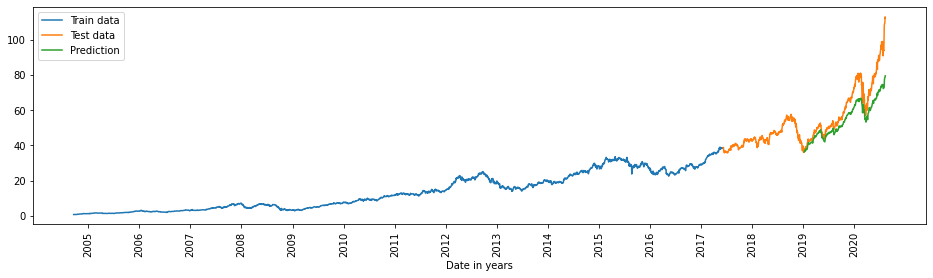

In [72]:
# desired feature of the data to plot
dim = 0

# plot train set
plt.figure(figsize=(16,4))
plt.plot(np.arange(0, df_train.shape[0]), sca.inverse_transform(df_train)[:, dim], label='Train data')

# plot train set
plt.plot(np.arange(df_train.shape[0], df_train.shape[0] + df_test.shape[0]), sca.inverse_transform(df_test)[:, dim], label='Test data')

# plot predictions of the test set
predictions = net(X_test.float()).detach()
plt.plot(np.arange(y_test.size(0)) + df_train.shape[0] + sequence_len, sca.inverse_transform(predictions)[:, dim], label='Prediction')

# extract dates 
df = pd.read_csv('AAPL.csv')
Dates = df.loc[Start_of_data:End_of_data, 'Date'].map(lambda x: pd.to_datetime(x).year)
val, ind = np.unique(Dates, return_index=True)
val = np.delete(val, np.where( np.diff(ind) < 100))
ind = np.delete(ind,  np.where( np.diff(ind) < 100))
plt.xlabel('Date in years')
plt.xticks(ticks=ind, labels=val, rotation=90)
plt.legend()